In [1]:
import time
import os
import torch
from torch import nn
import torch.nn.functional as F

from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
#ONLY RUN THIS ONCE
os.chdir("..")
os.path.abspath(os.curdir)

'/Users/claireboyd/courses/advanced_ml/dirty_comments_and_clean_plates'

#### Custom DataLoaders
Use classes and functions created in model_framework.py to frame out 4 different models using pytorch dataloaders...

In [3]:
import model_framework

In [4]:
FEATURES = [
    "stars",
    "review_count",
    "is_open",
    "n_reviews",
    "avg_rating",
    "IR_regular",
    "IR_follow_up",
    "IR_other",
    "Chester",
    "Bucks",
    "Philadelphia",
    "Delaware",
    "Montgomery",
    "Berks",
]

In [5]:
# train = pd.read_csv("data/phila/split/train.csv")
# subset for only features that are floats or ints
# train = train.select_dtypes(include=[np.float64,np.int64])

In [6]:
vectorizer = model_framework.Vectorizer
max_features = 7000
ngram_range = (1,1)

train_dataset = model_framework.ReviewsDataset(
    vectorizer=vectorizer,
    df_filepath="data/phila/split/train.csv",
    features=FEATURES,
    max_features=max_features,
    ngram_range=ngram_range
)
val_dataset = model_framework.ReviewsDataset(
    vectorizer=vectorizer,
    df_filepath="data/phila/split/val.csv",
    features=FEATURES,
    max_features=max_features,
    ngram_range=ngram_range
)
test_dataset = model_framework.ReviewsDataset(
    vectorizer=vectorizer,
    df_filepath="data/phila/split/test.csv",
    features=FEATURES,
    max_features=max_features,
    ngram_range=ngram_range
)

In [11]:
# train_tokens = train_dataset.vectorizer.get_feature_names_out()
# test_tokens = test_dataset.vectorizer.get_feature_names_out()
# val_tokens = test_dataset.vectorizer.get_feature_names_out()

In [7]:
train_dataset.vectorizer.get_feature_names_out()[:100]

array(['aback', 'ability', 'able', 'abruptly', 'absence', 'absent',
       'absolute', 'absolutely', 'absorb', 'absurd', 'abundance',
       'abundant', 'abv', 'abysmal', 'ac', 'acac', 'academy', 'accept',
       'acceptable', 'accepted', 'accepting', 'access', 'accessible',
       'accident', 'accidentally', 'accidents', 'accommodate',
       'accommodated', 'accommodating', 'accommodations', 'accompanied',
       'accompaniment', 'accompany', 'accompanying', 'according',
       'accordingly', 'account', 'accurate', 'accurately', 'accused',
       'acid', 'acidic', 'acidity', 'acknowledge', 'acknowledged',
       'acknowledgement', 'acknowledging', 'acme', 'acne', 'acoustics',
       'act', 'acted', 'acting', 'action', 'active', 'activity', 'acts',
       'actual', 'actually', 'ad', 'adam', 'adapt', 'add', 'added',
       'addicted', 'addicting', 'addictive', 'adding', 'addition',
       'additional', 'additionally', 'additions', 'address', 'addressed',
       'adds', 'adequate', 'adj

#### Experimenting with WeightedRandomSampler

In [44]:
def get_sampler(dataset):
    # https://towardsdatascience.com/demystifying-pytorchs-weightedrandomsampler-by-example-a68aceccb452
    class_counts = dataset.labels.value_counts()
    sample_weights = [1/class_counts[i] for i in dataset.labels.values]
    sampler = torch.utils.data.WeightedRandomSampler(weights=sample_weights, num_samples=len(train_dataset), replacement=True)
    return sampler

In [39]:
#imbalance of training dataset
class_counts = train_dataset.labels.value_counts()
class_counts

y
0    1381
1     373
Name: count, dtype: int64

In [45]:
train_sampler = get_sampler(train_dataset)
# val_sampler = get_sampler(val_dataset)
# test_sampler = get_sampler(test_dataset)

#### Model Testing

In [47]:
# wrap with any params here: https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
BATCH_SIZE = 32

train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=BATCH_SIZE,sampler=train_sampler)
val_dataloader = torch.utils.data.DataLoader(val_dataset,batch_size=BATCH_SIZE,shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=True)

In [48]:
example = next(iter(train_dataloader))
example

{'text': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 'labels': tensor([1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0,
         1, 1, 1, 1, 1, 1, 1, 1]),
 'features': tensor([[  2.5000,  26.0000,   1.0000,   4.0000,   2.5000,   1.0000,   0.0000,
            0.0000,   1.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  4.5000,  23.0000,   1.0000,   2.0000,   4.5000,   1.0000,   0.0000,
            0.0000,   1.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  4.5000,  15.0000,   1.0000,   5.0000,   5.0000,   1.0000,   0.0000,
            0.0000,   0.0000,   1.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  5.0000,   9.0000,   1.0000,   3.0000,   5.0000,   1.0000,   0.0000,
            0.0000,   0.0000,

In [49]:
def get_accuracy(val_dataloader, model, include_features=False):
    model.eval()
    
    with torch.no_grad():
        n_correct = 0
        n_examples = 0
        for data in val_dataloader:
            # get predicted probabilities, and labels with highest probability
            if include_features:
                predicted_labels = model(data['text'], data['features'])
            else:
                predicted_labels = model(data['text'])

            #compute argmax
            _, preds = torch.max(predicted_labels, 1)
            # _, labels = torch.max(data['labels'], 1)

            batch_correct = (preds == data['labels']).sum().item()
            n_correct += batch_correct
            n_examples += len(data['labels'])
    
    # calculate average accuracy across all batches
    average_accuracy = n_correct / n_examples
    return average_accuracy

In [50]:
def train_model(model, train_dataloader, val_dataloader, optimizer, loss_function, epochs, include_features=False):
 # Sets the module in training mode.
    val_accuracies=[]

    for n_epoch in range(epochs):

        model.train()

        for data in train_dataloader:
            if include_features:
                y_hat = model(data['text'], data['features'])
            else:
                y_hat = model(data['text'])

            optimizer.zero_grad()
            loss = loss_function(y_hat, data['labels'])
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        val_accuracies.append(get_accuracy(val_dataloader, model, include_features))
        
        if n_epoch % 100 == 0:
            print(f'At epoch {n_epoch} the loss is {loss:.3f}.')
    return val_accuracies

In [51]:
def plot_accuracies(val_accuracies):  
    plt.plot(range(1, len(val_accuracies)+1), val_accuracies)

### Logistic Regression

In [52]:
class LogisticRegression(torch.nn.Module):
   def __init__(self, input_dim, output_dim):
      super(LogisticRegression, self).__init__()
      self.linear = torch.nn.Linear(input_dim, output_dim)
   
   def forward(self, x):
      z = self.linear(x)
      y_hat = torch.sigmoid(z)
      return y_hat

In [61]:
input_dim = 7000 #vocab size
output_dim = 2 #probabilities for two output classes

log_regr_model = LogisticRegression(input_dim, output_dim)
epochs = 400
lr = 1e-03
optimizer = torch.optim.SGD(log_regr_model.parameters(), lr=lr)
loss_function = nn.NLLLoss()

log_regr_val_accuracies = train_model(log_regr_model, train_dataloader, val_dataloader, optimizer, loss_function, epochs)

At epoch 0 the loss is -0.502.
At epoch 100 the loss is -0.670.
At epoch 200 the loss is -0.784.
At epoch 300 the loss is -0.844.


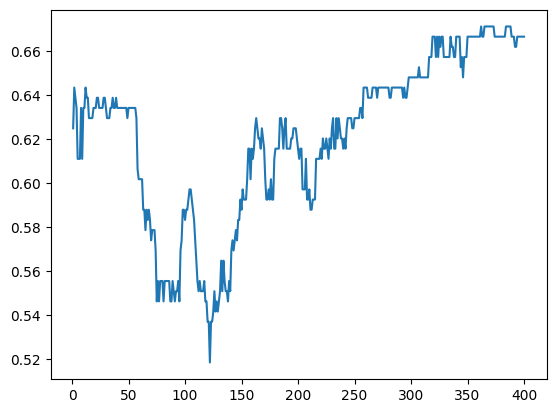

In [62]:
plot_accuracies(log_regr_val_accuracies)

In [58]:
class LogisticRegressionwithFeatures(torch.nn.Module):
   def __init__(self, input_dim, feature_dim, output_dim):
      super(LogisticRegressionwithFeatures, self).__init__()
      self.linear = torch.nn.Linear(input_dim, 1)
      self.feature_layer = torch.nn.Linear(feature_dim+1, output_dim)
      
   def forward(self, x, features):
      z = self.linear(x)
      z_features = torch.cat((z, features), 1)
      z_prime = self.feature_layer(z_features)
      y_hat = torch.sigmoid(z_prime)
      return y_hat

In [59]:
input_dim = 7000 #vocab size
feature_dim = len(FEATURES)
output_dim = 2 #probabilities for two output classes

log_regr_model = LogisticRegressionwithFeatures(input_dim, feature_dim, output_dim)
epochs = 500
lr = 1e-04
optimizer = torch.optim.SGD(log_regr_model.parameters(), lr=lr)
loss_function = nn.NLLLoss()

log_regr_val_accuracies_with_features = train_model(log_regr_model, train_dataloader, val_dataloader, optimizer, loss_function, epochs, include_features=True)

At epoch 0 the loss is -0.468.
At epoch 100 the loss is -0.926.
At epoch 200 the loss is -0.978.
At epoch 300 the loss is -0.995.
At epoch 400 the loss is -0.992.


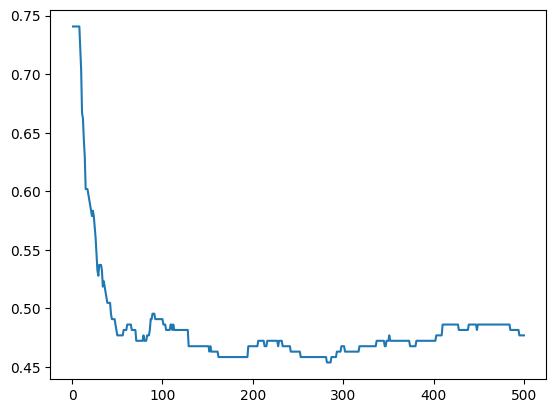

In [60]:
plot_accuracies(log_regr_val_accuracies_with_features)

#### SVM

In [63]:
class Binary_SVM(nn.Module):
    def __init__(self, n_features):
        super(Binary_SVM, self).__init__()
        self.linear = nn.Linear(n_features, 1)
    
    def forward(self, x):
        out = self.linear(x)
        return out

In [33]:
max_features=7000
svm_model = Binary_SVM(max_features)
epochs=300
lr = 1e-05
l1_reg = 0.01

optimizer = torch.optim.SGD(svm_model.parameters(), lr=lr, weight_decay=l1_reg)
loss_function = nn.MultiMarginLoss()

swm_val_accuracies = train_model(svm_model, train_dataloader, val_dataloader, optimizer, loss_function, epochs)

At epoch 0 the loss is 0.500.
At epoch 100 the loss is 0.500.
At epoch 200 the loss is 0.499.


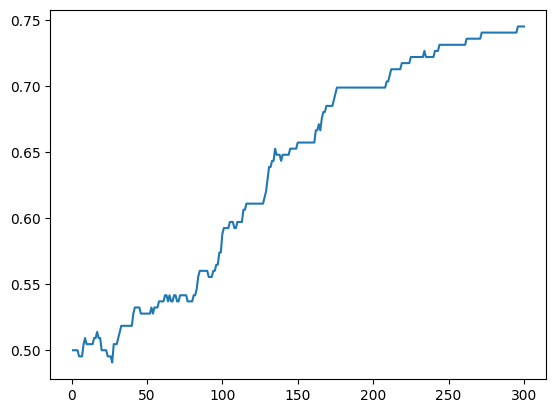

In [35]:
plot_accuracies(swm_val_accuracies)

### XGBoost